In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from scipy import stats
from scipy.special import expit as logistic

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

#### Code 12.1

In [3]:
d = pd.read_csv('Data/reedfrogs.csv', sep=",")
print(d.shape)
d.head(8)

(48, 5)


,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9
5,10,no,small,9,0.9
6,10,no,small,10,1.0
7,10,no,small,9,0.9


#### Code 12.2

In [4]:
# make the tank cluster variable
tank = np.arange(d.shape[0])
# fit
with pm.Model() as m_12_1:
    a_tank = pm.Normal('a_tank', 0, 5, shape=d.shape[0])
    p = pm.math.invlogit(a_tank[tank])
    surv = pm.Binomial('surv', n=d.density, p=p, observed=d.surv)
    trace_12_1 = pm.sample(2000, tune=2000)
# az.summary(trace_12_1, credible_interval=.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a_tank]
100%|██████████| 4000/4000 [00:21<00:00, 189.86it/s]


#### Code 12.3

In [5]:
with pm.Model() as m_12_2:
    a = pm.Normal('a', 0., 1.)
    sigma = pm.HalfCauchy('sigma', 1.)
    a_tank = pm.Normal('a_tank', a, sigma, shape=d.shape[0])
    p = pm.math.invlogit(a_tank[tank])
    surv = pm.Binomial('surv', n=d.density, p=p, observed=d.surv)
    trace_12_2 = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a_tank, sigma, a]
100%|██████████| 4000/4000 [00:17<00:00, 224.50it/s]


#### Code 12.4

In [6]:
comp_df = az.compare({'m12_1' : trace_12_1,
                      'm12_2' : trace_12_2})

comp_df

/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m12_2,201.172,21.4005,0,0.605597,8.9594,0,True,deviance
m12_1,202.298,23.0201,1.1264,0.394403,6.94023,4.55739,True,deviance


#### Code 12.5

In [7]:
# extract PyMC3 samples
post = pm.trace_to_dataframe(trace_12_2, varnames=['a_tank'])

# compute median intercept for each tank
# also transform to probability with logistic
d.loc[:, 'propsurv_est'] = pd.Series(logistic(post.median(axis=0).values), index=d.index)

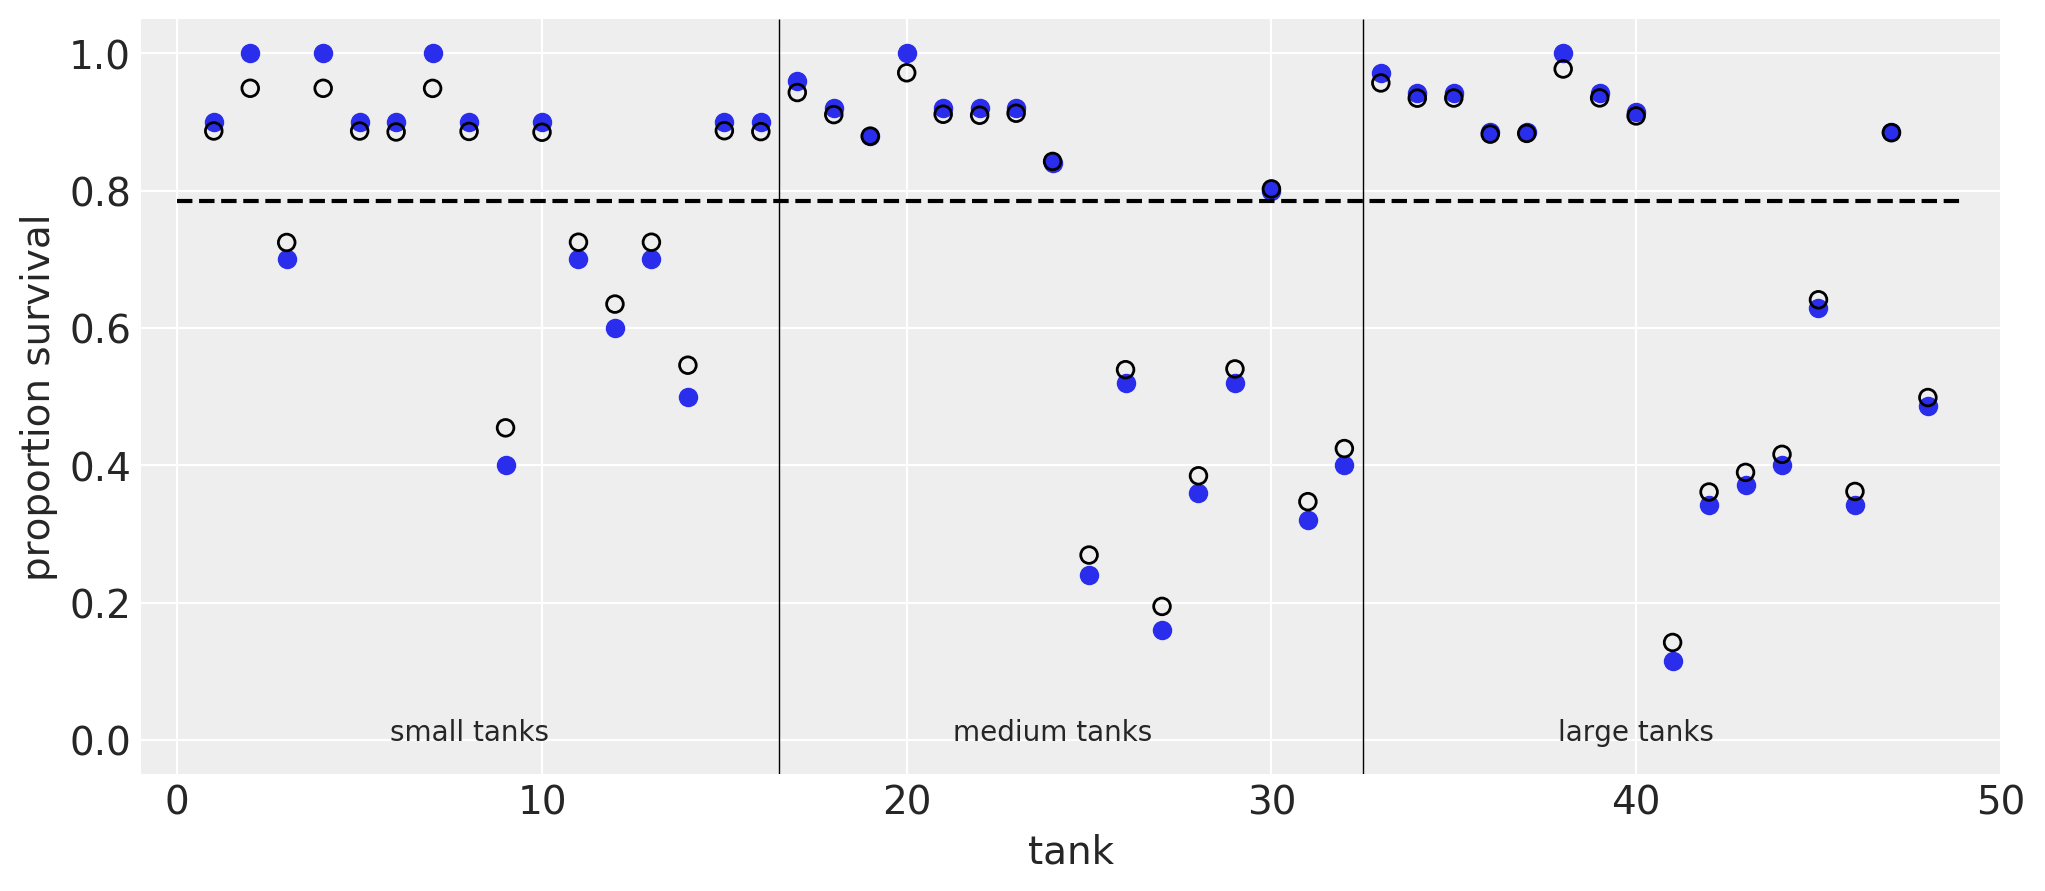

In [8]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
# display raw proportions surviving in each tank
ax.scatter(np.arange(1, 49), d.propsurv)
ax.scatter(np.arange(1, 49), d.propsurv_est,
             facecolors='none', edgecolors='k', lw=1)
ax.hlines(logistic(np.median(trace_12_2['a'], axis=0)), 0, 49, linestyles='--')
ax.vlines([16.5, 32.5], -.05, 1.05, lw=.5)
ax.text(8, 0, "small tanks", horizontalalignment='center')
ax.text(16+8, 0, "medium tanks", horizontalalignment='center')
ax.text(32+8, 0, "large tanks", horizontalalignment='center')
ax.set_xlabel('tank', fontsize=14)
ax.set_ylabel('proportion survival', fontsize=14)
ax.set_xlim(-1, 50)
ax.set_ylim(-.05, 1.05);

#### Code 12.6

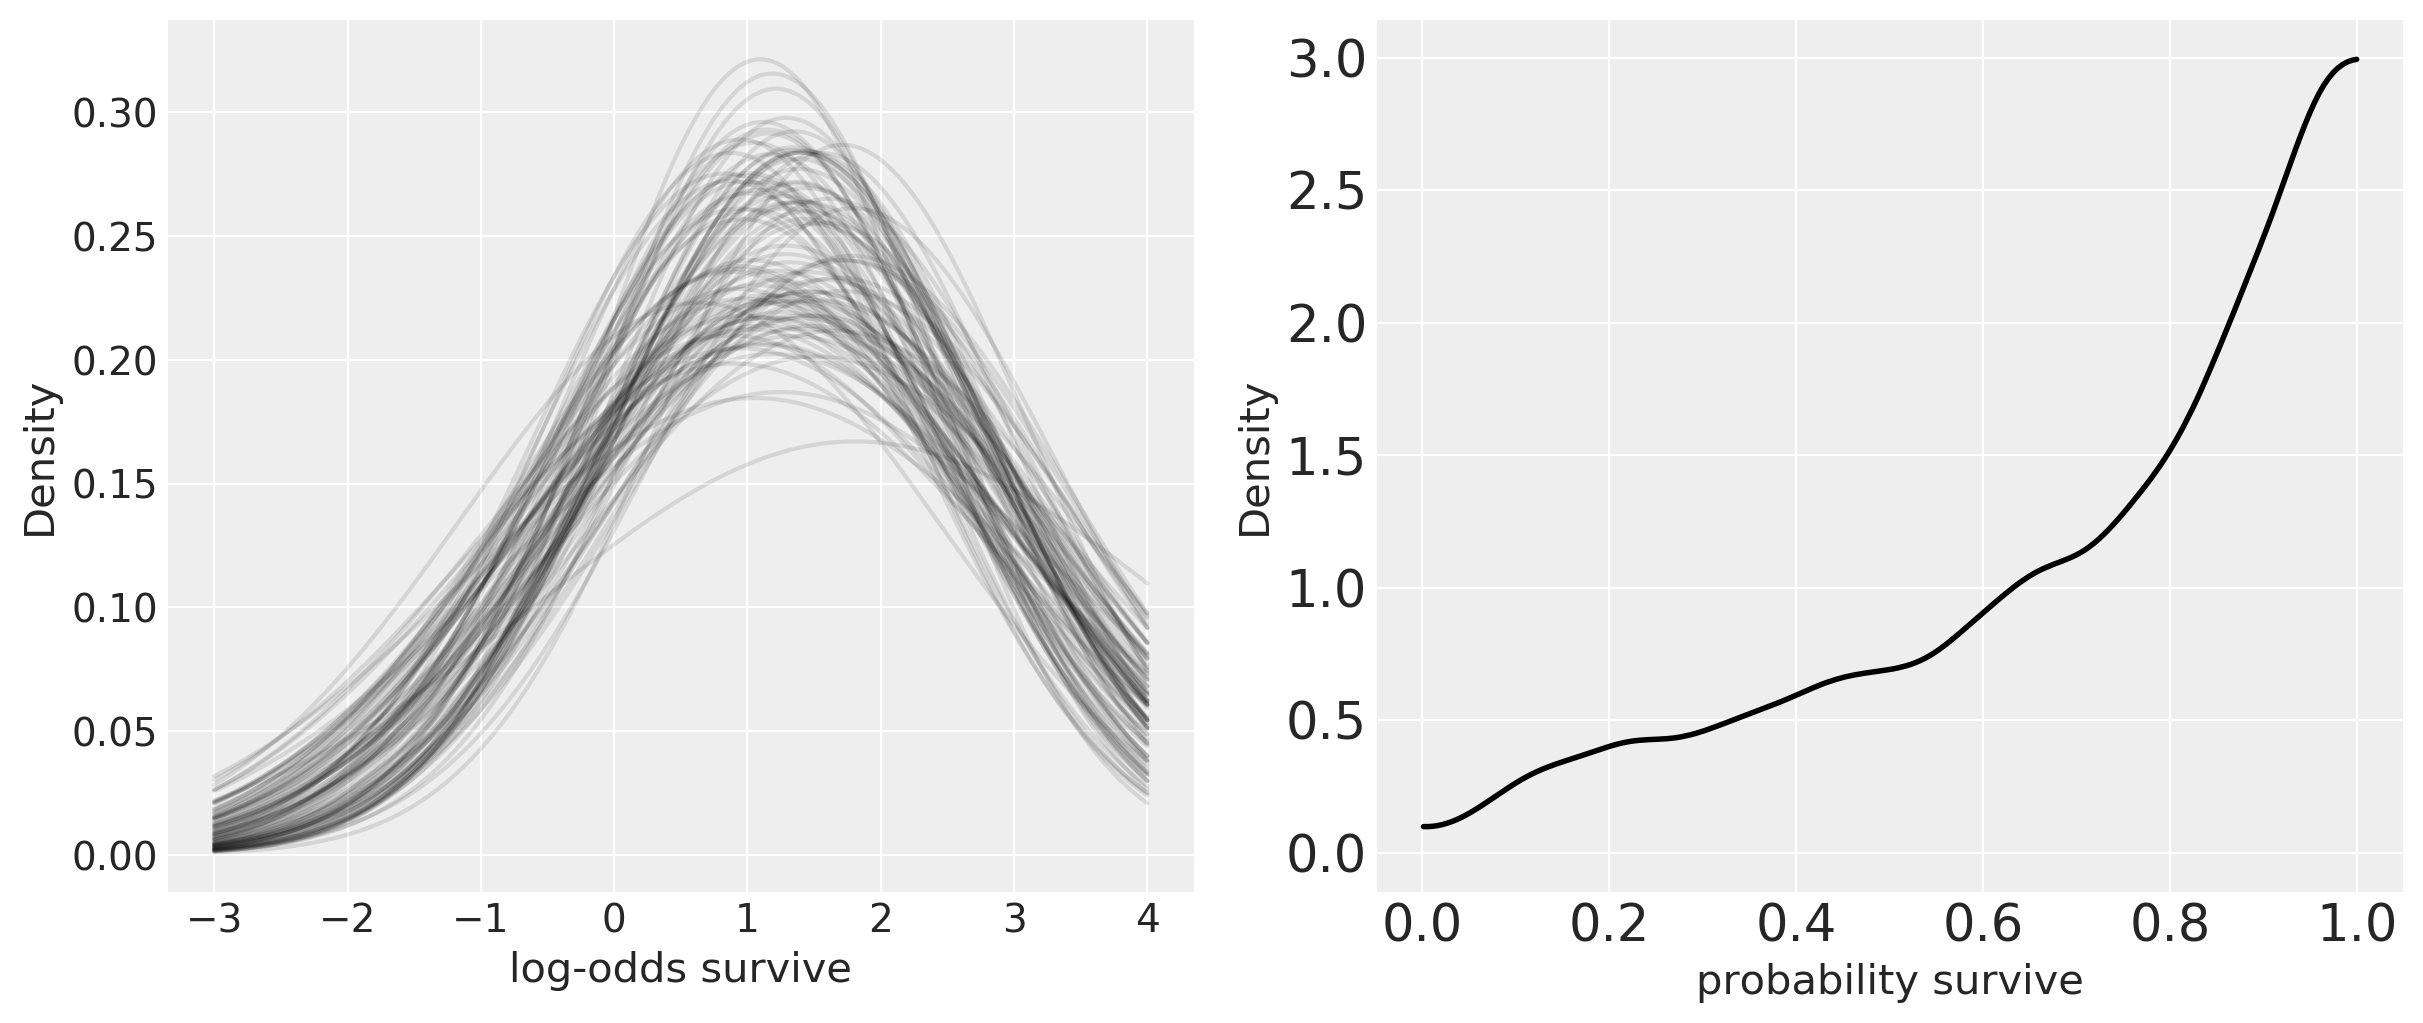

In [9]:
_, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
# show first 100 populations in the posterior
xrange = np.linspace(-3, 4, 200)
postcurve = [stats.norm.pdf(xrange, loc=trace_12_2['a'][i], scale=trace_12_2['sigma'][i]) for i in range(100)]
ax[0].plot(xrange, np.asarray(postcurve).T,
           alpha=.1, color='k')
ax[0].set_xlabel('log-odds survive')
ax[0].set_ylabel('Density');
# sample 8000 imaginary tanks from the posterior distribution
sim_tanks = np.random.normal(loc=trace_12_2['a'], scale=trace_12_2['sigma'])
# transform to probability and visualize
az.plot_kde(logistic(sim_tanks), ax=ax[1], plot_kwargs={'color':'k'})
ax[1].set_xlabel('probability survive')
ax[1].set_ylabel('Density');

#### Code 12.7

In [10]:
a, sigma, nponds = 1.4, 1.5, 60
ni = np.repeat([5, 10, 25, 35], 15)

#### Code 12.8

In [11]:
a_pond = np.random.normal(loc=a, scale=sigma, size=nponds)

#### Code 12.9

In [12]:
dsim = pd.DataFrame(dict(pond=np.arange(nponds), ni=ni, true_a=a_pond))

#### Code 12.10
Data types related. Python is dynamically-typed.

#### Code 12.11

In [13]:
dsim.loc[:, 'si'] = np.random.binomial(dsim['ni'], logistic(dsim['true_a']))

#### Code 12.12

In [14]:
dsim.loc[:, 'p_nopool'] = dsim.si / dsim.ni

#### Code 12.13

In [15]:
with pm.Model() as m_12_3:
    a = pm.Normal('a', 0., 1.)
    sigma = pm.HalfCauchy('sigma', 1.)
    a_pond = pm.Normal('a_pond', a, sigma, shape=nponds)
    p = pm.math.invlogit(a_pond[dsim.pond.values])
    si = pm.Binomial('si', n=dsim.ni.values, p=p, observed=dsim.si)
    trace_12_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a_pond, sigma, a]
100%|██████████| 2000/2000 [00:07<00:00, 283.99it/s]


#### Code 12.14

In [16]:
summary_12_3 = az.summary(trace_12_3, credible_interval=.89, round_to=2)
summary_12_3.iloc[[0, 1, 2, -3, -2, -1],:]

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.10,0.22,0.74,1.42,0.01,0.00,1586.10,1573.20,1608.73,1358.40,1.0
a_pond[0],2.43,1.14,0.53,4.14,0.02,0.02,2086.46,1404.69,2318.16,937.35,1.0
a_pond[1],2.42,1.13,0.58,4.13,0.02,0.02,2606.69,1778.75,2917.60,1314.39,1.0
a_pond[58],3.10,0.75,1.92,4.33,0.02,0.01,1827.55,1493.05,2051.49,1343.72,1.0
a_pond[59],-1.25,0.43,-1.90,-0.55,0.01,0.01,2660.53,1945.53,2821.48,1105.96,1.0
sigma,1.52,0.20,1.19,1.82,0.01,0.00,931.50,902.18,968.69,1088.00,1.0


#### Code 12.15

In [17]:
estimated_a_pond = az.summary(trace_12_3, credible_interval=.89, var_names=['a_pond'])
dsim.loc[:, 'p_partpool'] = logistic(estimated_a_pond['mean'].values)

#### Code 12.16

In [18]:
dsim.loc[:, 'p_true'] = logistic(dsim['true_a'].values)

#### Code 12.17

In [19]:
nopool_error = np.abs(dsim.p_nopool - dsim.p_true)
partpool_error = np.abs(dsim.p_partpool - dsim.p_true)

#### Code 12.18

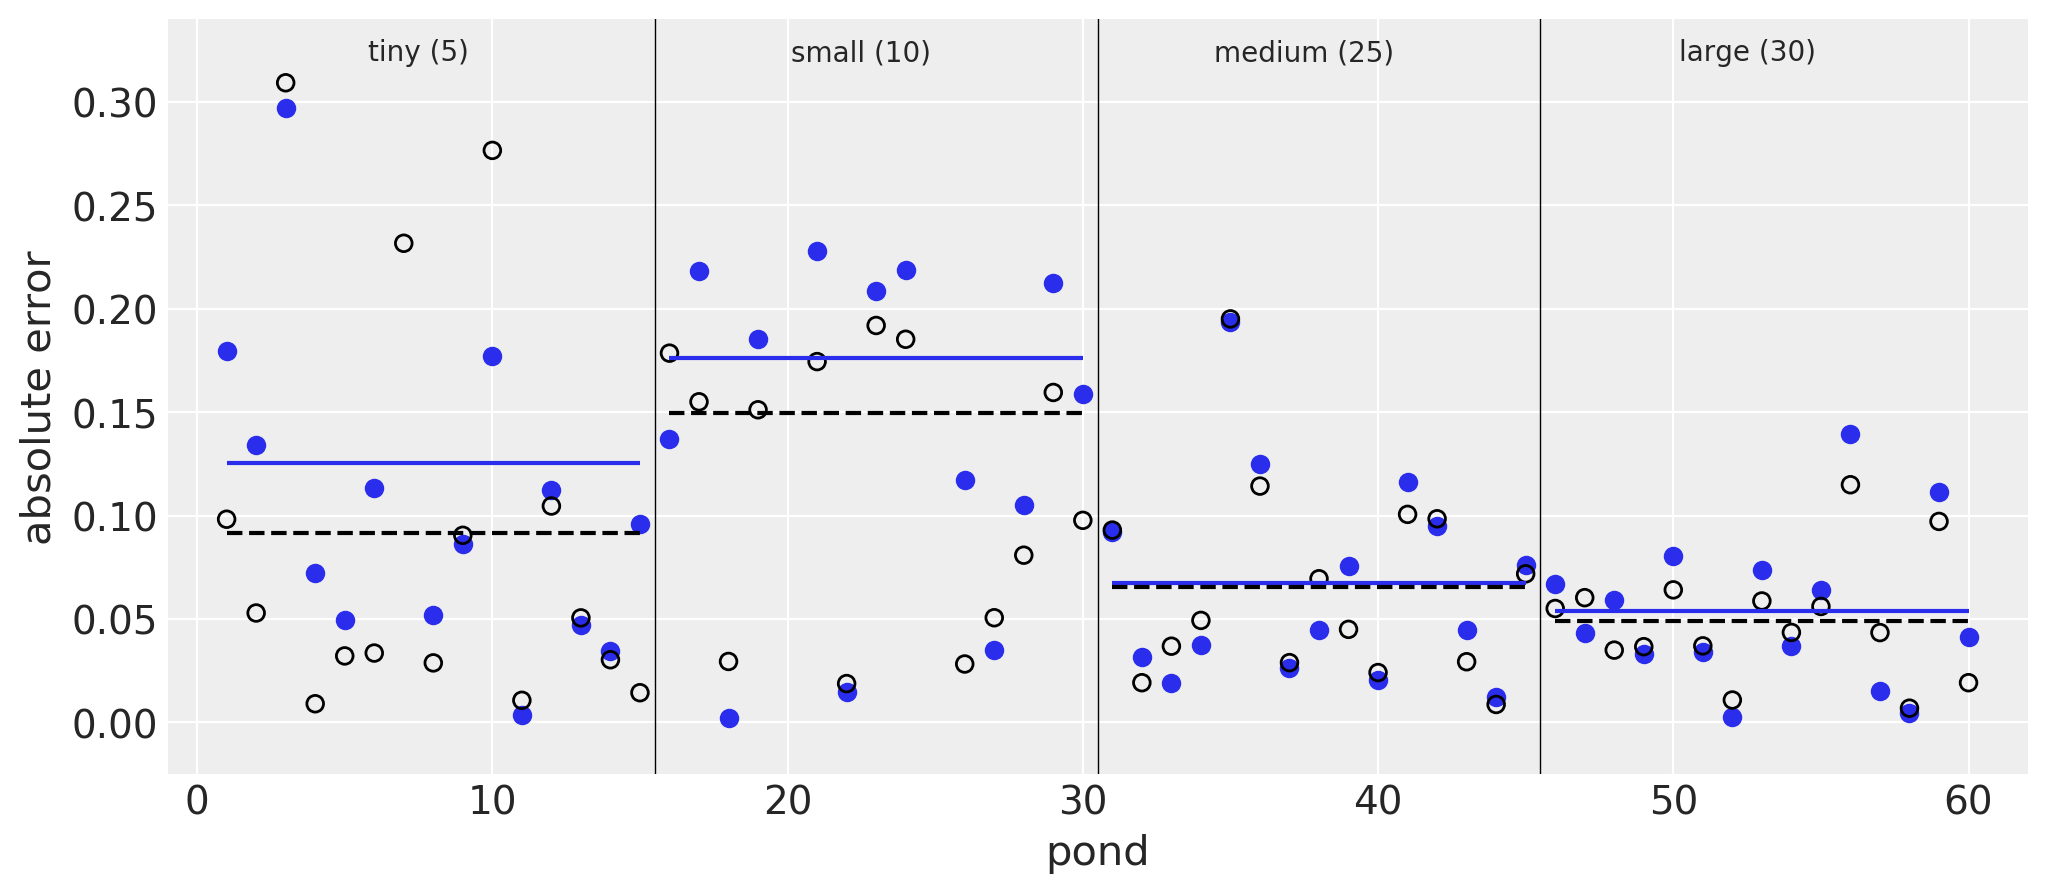

In [20]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
xrange = np.arange(60)
xrange_ = xrange.reshape((4, 15))
# display raw proportions surviving in each tank
ax.scatter(xrange+1, nopool_error)
ax.scatter(xrange+1, partpool_error,
             facecolors='none', edgecolors='k', lw=1)
ax.vlines(xrange_[1:,0]+.5, -.025, 0.35, lw=.5)

textall = ["tiny (5)", "small (10)", "medium (25)", "large (30)"]
for isem in range(4):
    ax.hlines(nopool_error[xrange_[isem, :]].mean(), 
              xrange_[isem, 0]+1, xrange_[isem, -1]+1, color='C0')
    ax.hlines(partpool_error[xrange_[isem, :]].mean(), 
              xrange_[isem, 0]+1, xrange_[isem, -1]+1, color='k', linestyles='--')
    ax.text(xrange_[isem, 7]+.5, 0.32, textall[isem], horizontalalignment='center')
ax.set_xlabel('pond')
ax.set_ylabel('absolute error')
ax.set_xlim(-1, 62)
ax.set_ylim(-.025, 0.34);

#### Code 12.19

This part is more Stan and rethinking related. To do the same in PyMC3 (i.e., avoid compiling the same model twice), you need to set up the input data with `theano.shared` or use [sampled](https://github.com/ColCarroll/sampled), a functional decorator for PyMC3.

#### Code 12.20

In [21]:
y1 = np.random.normal(10., 1., 10000)
y2 = 10. + np.random.normal(0., 1., 10000)

#### Code 12.21

In [22]:
d = pd.read_csv('Data/chimpanzees.csv', sep=";")
# we change "actor" to zero-index
d.actor = (d.actor - 1).astype(int)
Nactor = len(d.actor.unique())

with pm.Model() as m_12_4:
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    
    a = pm.Normal('a', 0, 10)
    sigma_actor = pm.HalfCauchy('sigma_actor', 1.)
    a_actor = pm.Normal('a_actor', 0., sigma_actor, shape=Nactor)

    p = pm.math.invlogit(a + a_actor[d.actor.values] + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_12_4 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a_actor, sigma_actor, a, bpC, bp]
100%|██████████| 6000/6000 [01:47<00:00, 55.77it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46122493044441554, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


#### Code 12.22

In [23]:
total_a_actor = np.asarray([trace_12_4['a'] + trace_12_4['a_actor'][:, i] for i in range(Nactor)])
total_a_actor.mean(axis=1).round(2)

array([-0.71,  4.67, -1.02, -1.02, -0.71,  0.23,  1.76])

#### Code 12.23

In [24]:
d.block = (d.block - 1).astype(int)
Nblock = len(d.block.unique())

with pm.Model() as m_12_5:
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    
    a = pm.Normal('a', 0, 10)
    sigma_actor = pm.HalfCauchy('sigma_actor', 1.)
    a_actor = pm.Normal('a_actor', 0., sigma_actor, shape=Nactor)

    sigma_block = pm.HalfCauchy('sigma_block', 1.)
    a_block = pm.Normal('a_block', 0., sigma_block, shape=Nblock)
    
    p = pm.math.invlogit(a + a_actor[d.actor.values] + a_block[d.block.values]
                         + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_12_5 = pm.sample(6000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a_block, sigma_block, a_actor, sigma_actor, a, bpC, bp]
100%|██████████| 7000/7000 [02:36<00:00, 44.60it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


#### Code 12.24

In [25]:
az.summary(trace_12_5, credible_interval=.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bp,0.83,0.26,0.40,1.25,0.00,0.00,9263.83,9127.09,9270.33,7333.03,1.0
bpC,-0.14,0.30,-0.63,0.33,0.00,0.00,9789.15,7293.02,9782.93,8988.71,1.0
a,0.41,1.01,-1.09,1.95,0.02,0.02,2314.28,2007.65,2494.51,2745.45,1.0
a_actor[0],-1.13,1.02,-2.76,0.33,0.02,0.02,2418.86,2235.55,2593.54,3003.37,1.0
a_actor[1],4.23,1.70,1.85,6.59,0.03,0.02,3827.70,2972.02,5075.50,3726.61,1.0
a_actor[2],-1.43,1.02,-3.06,0.01,0.02,0.02,2411.69,2213.91,2574.89,2857.62,1.0
a_actor[3],-1.44,1.01,-3.13,-0.05,0.02,0.02,2344.05,2164.02,2524.55,2881.26,1.0
a_actor[4],-1.13,1.02,-2.70,0.37,0.02,0.02,2379.67,2150.96,2565.61,2802.75,1.0
a_actor[5],-0.18,1.01,-1.71,1.34,0.02,0.02,2382.73,2071.77,2557.00,2923.53,1.0
a_actor[6],1.36,1.05,-0.21,2.94,0.02,0.02,2485.70,2410.84,2671.78,3158.86,1.0


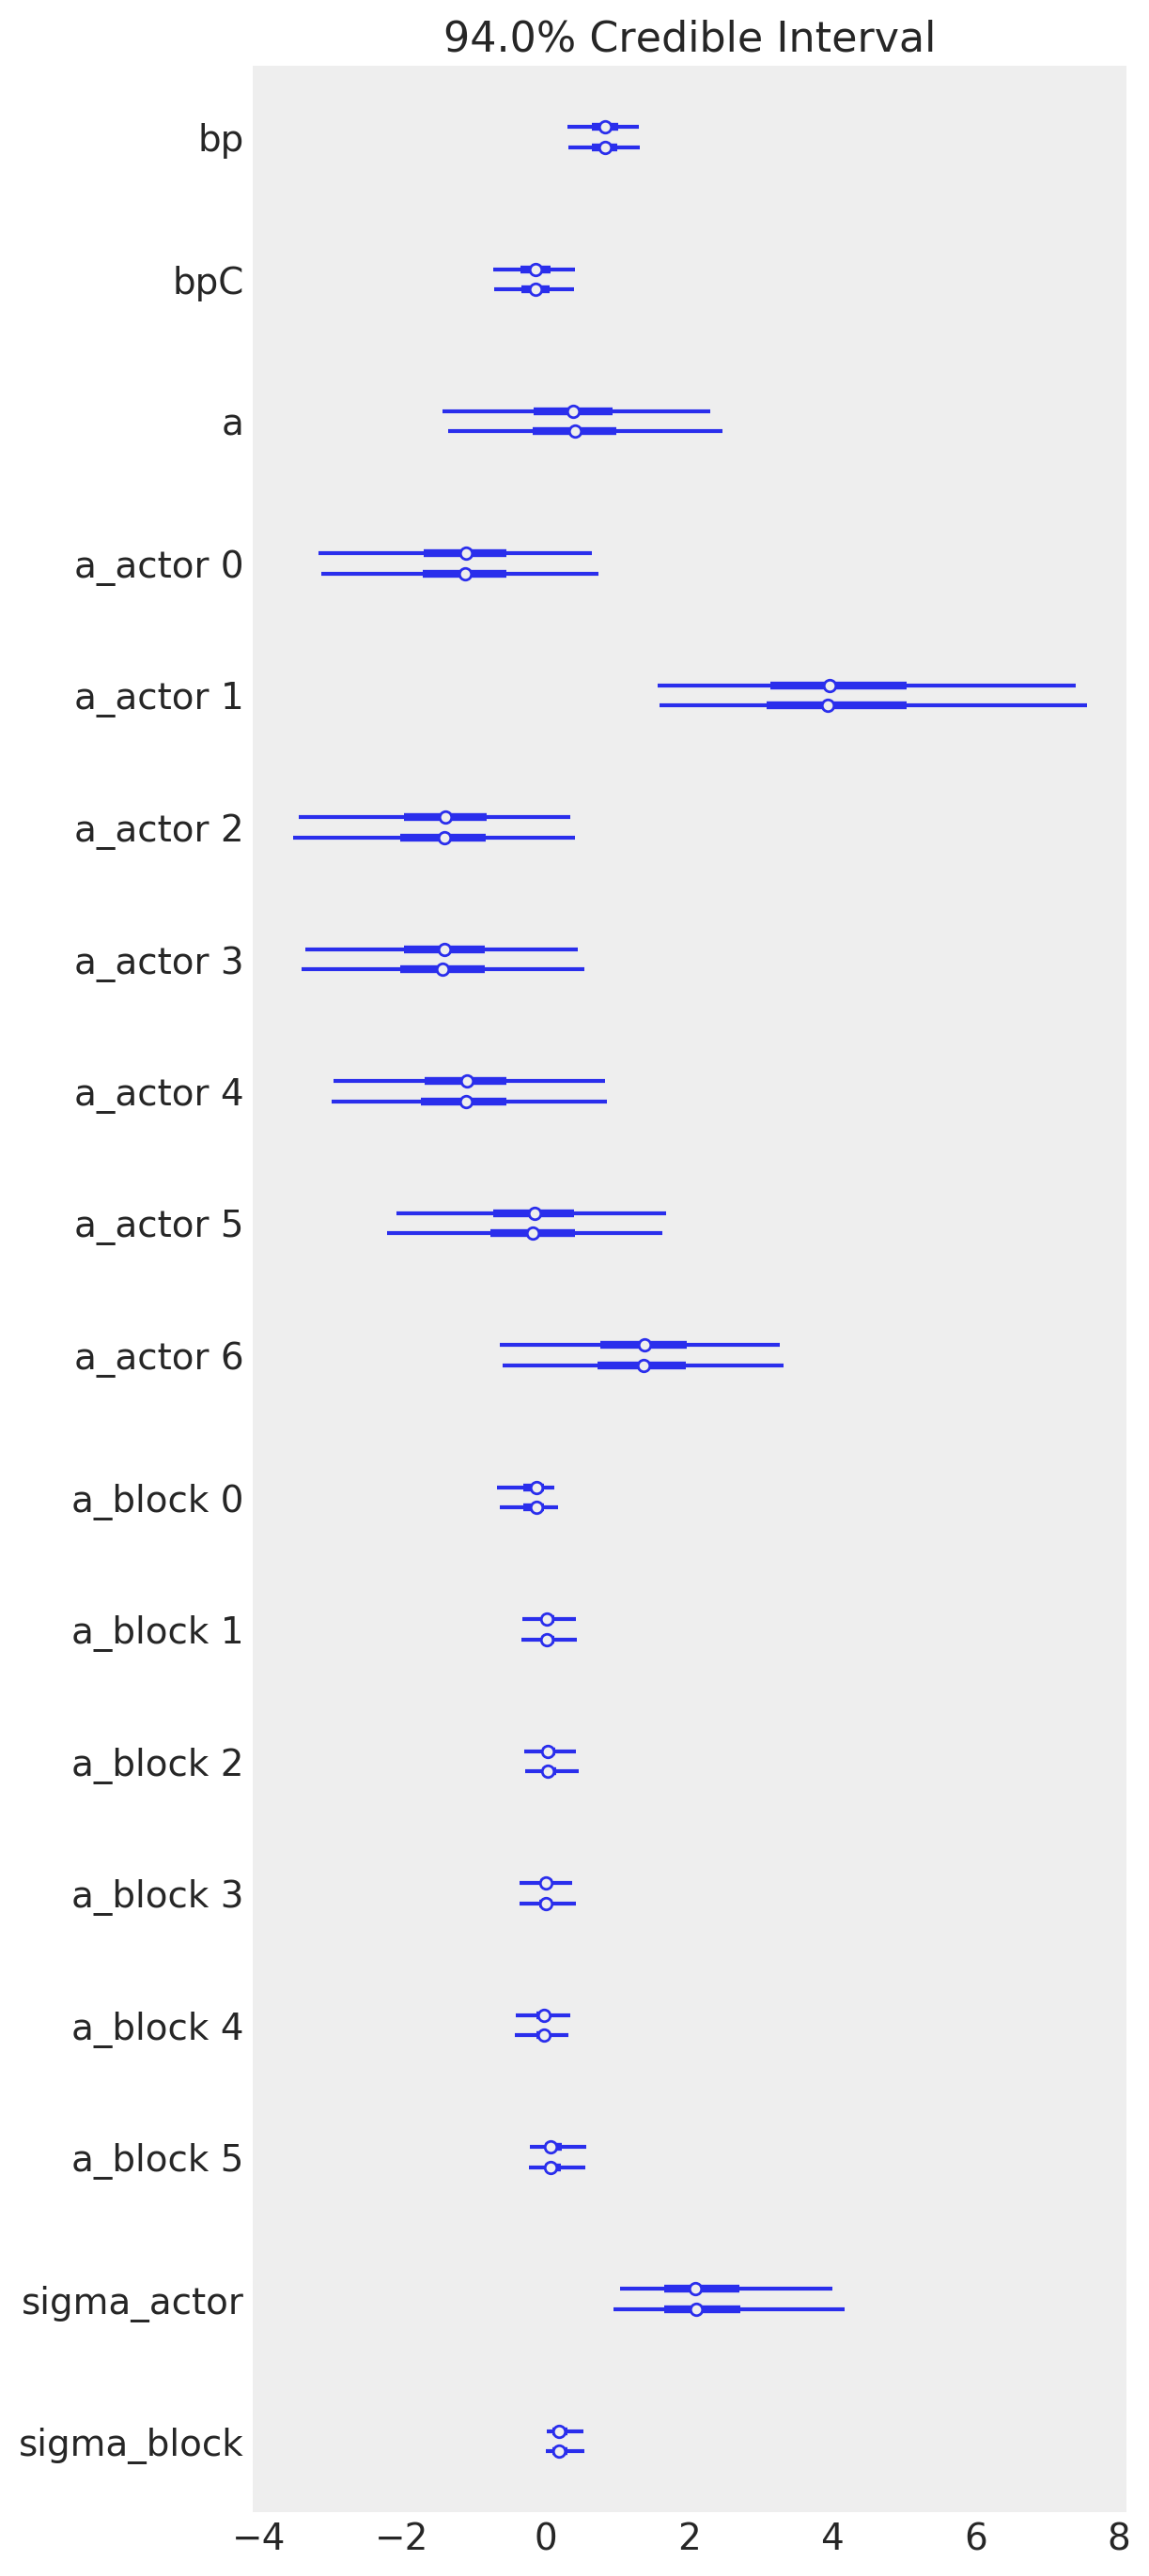

In [26]:
az.plot_forest(trace_12_5);

#### Code 12.25

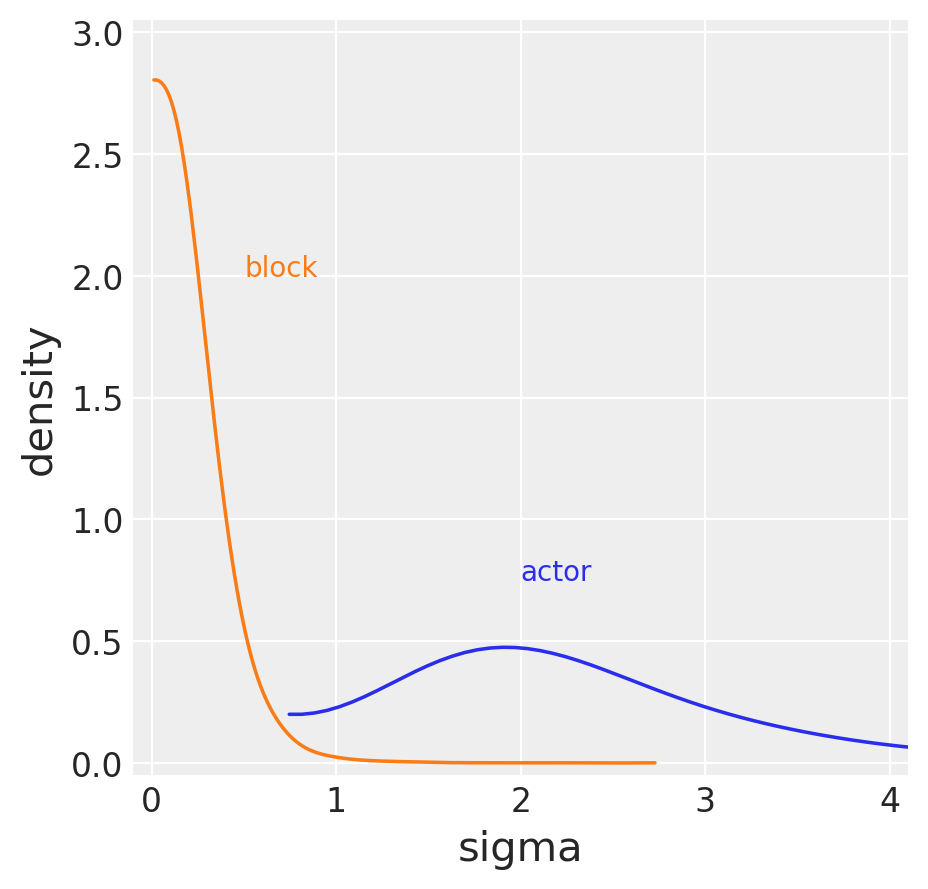

In [27]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
az.plot_kde(trace_12_5['sigma_actor'], ax=ax)
az.plot_kde(trace_12_5['sigma_block'], ax=ax, plot_kwargs={'color':'C1'})
ax.text(2, 0.75, "actor", color='C0')
ax.text(0.5, 2, "block", color='C1')
ax.set_xlabel('sigma')
ax.set_ylabel('density')
ax.set_xlim(-0.1, 4.1)
ax.set_ylim(-0.05, 3.05);

#### Code 12.26

In [28]:
comp_df = az.compare({'m12_4' : trace_12_4, 
                      'm12_5' : trace_12_5})

comp_df

,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m12_4,531.515,8.22593,0,0.638174,19.849,0,False,deviance
m12_5,532.829,10.5203,1.31394,0.361826,20.1438,1.81522,False,deviance


#### Code 12.27

In [29]:
chimp = 2 - 1
sel_actor = np.where((d.actor == (chimp)).values)[0]
_, uni_cond = np.unique(d.loc[sel_actor, ['condition', 'prosoc_left']], 
                        axis=0, return_index=True, )
d.loc[sel_actor[uni_cond], :].head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
73,1,NaN,0,0,3,0,0,1
72,1,NaN,0,0,1,1,1,1
108,1,7.0,1,0,2,0,0,1
116,1,5.0,1,1,16,1,1,1


In [30]:
ppc = pm.sample_posterior_predictive(trace=trace_12_4, samples=1000, model=m_12_4)

100%|██████████| 1000/1000 [00:02<00:00, 476.28it/s]


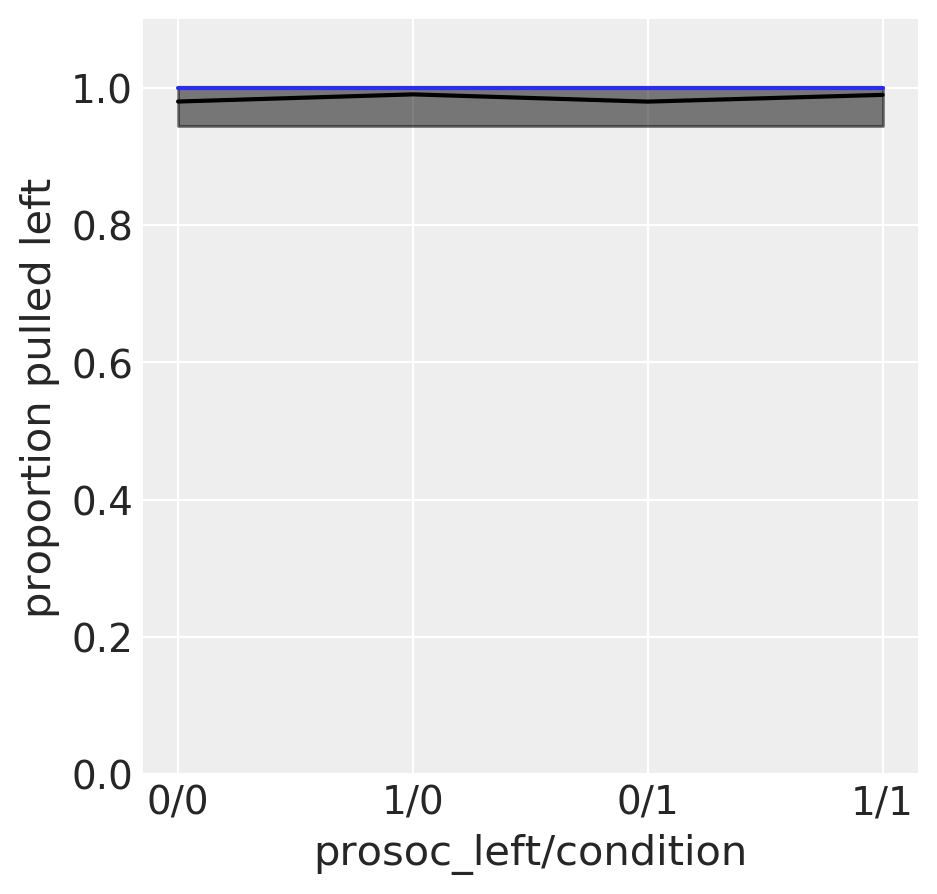

In [31]:
rt = ppc['pulled_left'][:, sel_actor]

pred_mean = np.zeros((1000, 4))
cond = d.condition.unique()
prosoc_l = d.prosoc_left.unique()
for i in range(len(rt)):
    tmp = []
    for cp in cond:
        for pl in prosoc_l:
            tmp.append(np.mean(rt[i][(d.prosoc_left[sel_actor].values==pl) &
                                     (d.condition[sel_actor].values==cp)]))
    pred_mean[i] = tmp
    
mp = pred_mean.mean(0)

_, ax = plt.subplots(1, 1, figsize=(5, 5))
az.plot_hpd(range(4), pred_mean, credible_interval=.89, color='k')

ax.plot(mp, color='k')
chimps = d.groupby(['actor', 'prosoc_left', 'condition']).agg('mean')['pulled_left'].values.reshape(7, -1)
ax.plot(chimps[chimp], 'C0')

ax.set_ylim(0, 1.1)
ax.set_xlabel("prosoc_left/condition")
ax.set_ylabel("proportion pulled left")
plt.xticks(range(4), ("0/0","1/0","0/1","1/1"));

#### Code 12.28

In [32]:
post = pm.trace_to_dataframe(trace_12_4)
post.head()

,bp,bpC,a,a_actor__0,a_actor__1,a_actor__2,a_actor__3,a_actor__4,a_actor__5,a_actor__6,sigma_actor
0,0.582494,0.182410,0.658941,-1.583467,3.583105,-1.724373,-1.801611,-1.125099,-0.217567,1.147565,2.009289
1,0.930436,-0.361265,0.134850,-0.624139,5.772224,-1.159624,-1.068659,-1.153411,0.027954,1.641516,2.513702
2,0.746710,-0.148143,0.239409,-0.706640,2.209999,-1.145467,-1.109564,-1.181941,-0.006613,1.473592,1.253854
3,0.725961,-0.324211,0.331691,-1.087444,3.218368,-1.274962,-1.242846,-0.587186,0.014764,1.805136,1.355438
4,0.515669,0.015680,0.243630,-0.733438,3.653955,-1.026808,-1.553243,-0.924059,0.168191,1.422787,1.457433


#### Code 12.29

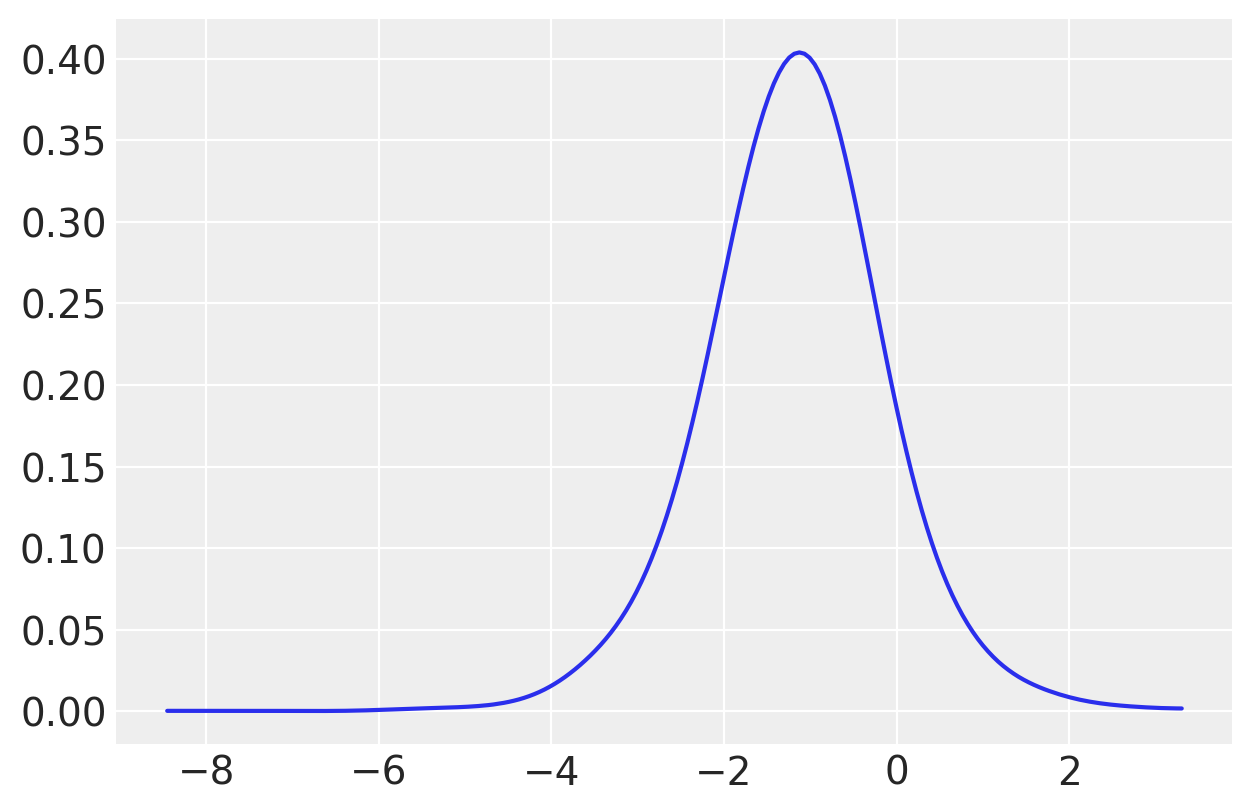

In [33]:
az.plot_kde(trace_12_4['a_actor'][:, 5-1]);

#### Code 12.30

In [34]:
def p_link(prosoc_left, condition, actor, trace):
    logodds = (trace['a'] +
               trace['a_actor'][:, actor] +
               (trace['bp'] + trace['bpC'] * condition) * prosoc_left)
    return logistic(logodds)

#### Code 12.31

In [35]:
prosoc_left = [0,1,0,1]
condition = [0,0,1,1]

pred_raw = np.asarray([p_link(p_l, c_d, 2-1, trace_12_4) 
                       for p_l, c_d in zip(prosoc_left, condition)]).T
pred_p = pred_raw.mean(axis=0)
pred_p_PI = az.hpd(pred_raw, credible_interval=.89)

#### Code 12.32

In [36]:
d_pred = pd.DataFrame(dict(prosoc_left=[0, 1, 0, 1],
                           condition=[0, 0, 1, 1],
                           actor=np.repeat(2-1, 4)))

#### Code 12.33

In [37]:
# replace varying intercept samples with zeros
# 1000 samples by 7 actors
a_actor_zeros = np.zeros((1000, 7))

#### Code 12.34

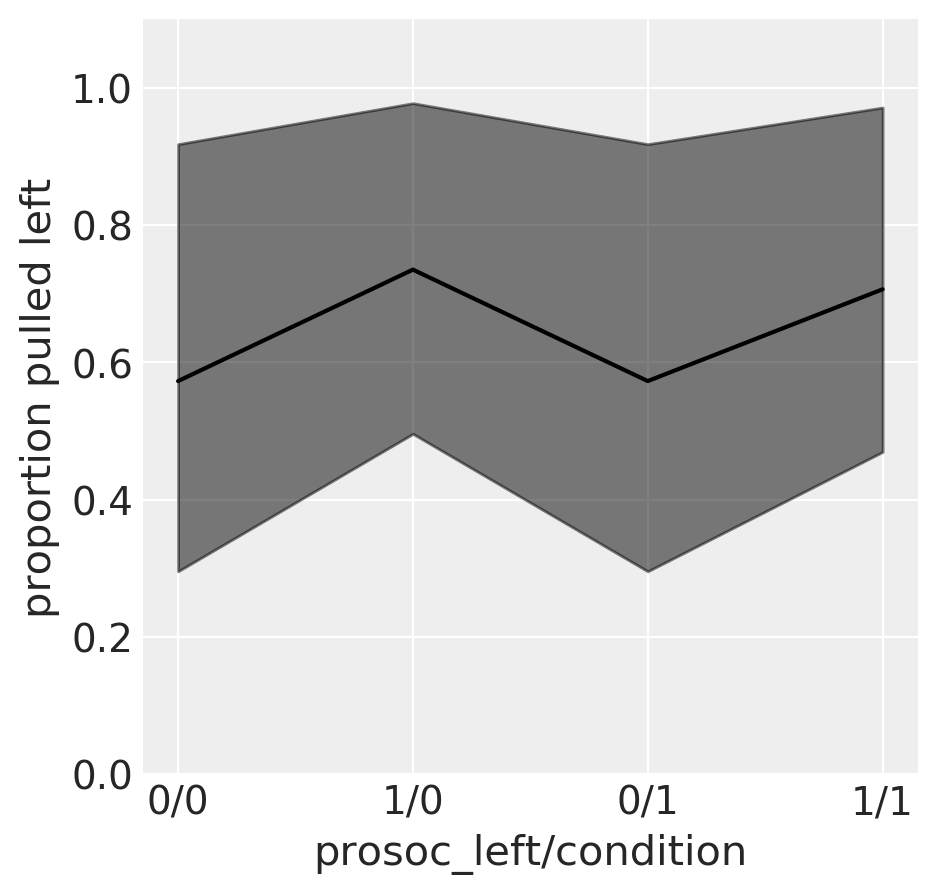

In [38]:
def p_link(prosoc_left, condition, actor_sim, trace):
    Nsim = actor_sim.shape[0]//trace.nchains
    trace = trace[:Nsim]
    logodds = trace['a'] + \
                np.mean(actor_sim, axis=1) + \
                (trace['bp'] + trace['bpC'] * condition) * prosoc_left
    return logistic(logodds)

pred_raw = np.asarray([p_link(p_l, c_d, a_actor_zeros, trace_12_4) 
                       for p_l, c_d in zip(prosoc_left, condition)]).T
pred_p = pred_raw.mean(axis=0)
_, ax = plt.subplots(1, 1, figsize=(5, 5))

az.plot_hpd(range(4), pred_raw, credible_interval=.89, color='k', smooth=False)
ax.plot(pred_p, color='k')

ax.set_ylim(0, 1.1)
ax.set_xlabel("prosoc_left/condition")
ax.set_ylabel("proportion pulled left")
plt.xticks(range(4), ("0/0","1/0","0/1","1/1"));

#### Code 12.35

In [39]:
# replace varying intercept samples with simulations
sigma_actor = trace_12_4.get_values('sigma_actor')
a_actor_sims = np.random.normal(loc=0, 
                                scale=np.reshape(sigma_actor[:7000], (1000, 7)))

#### Code 12.36

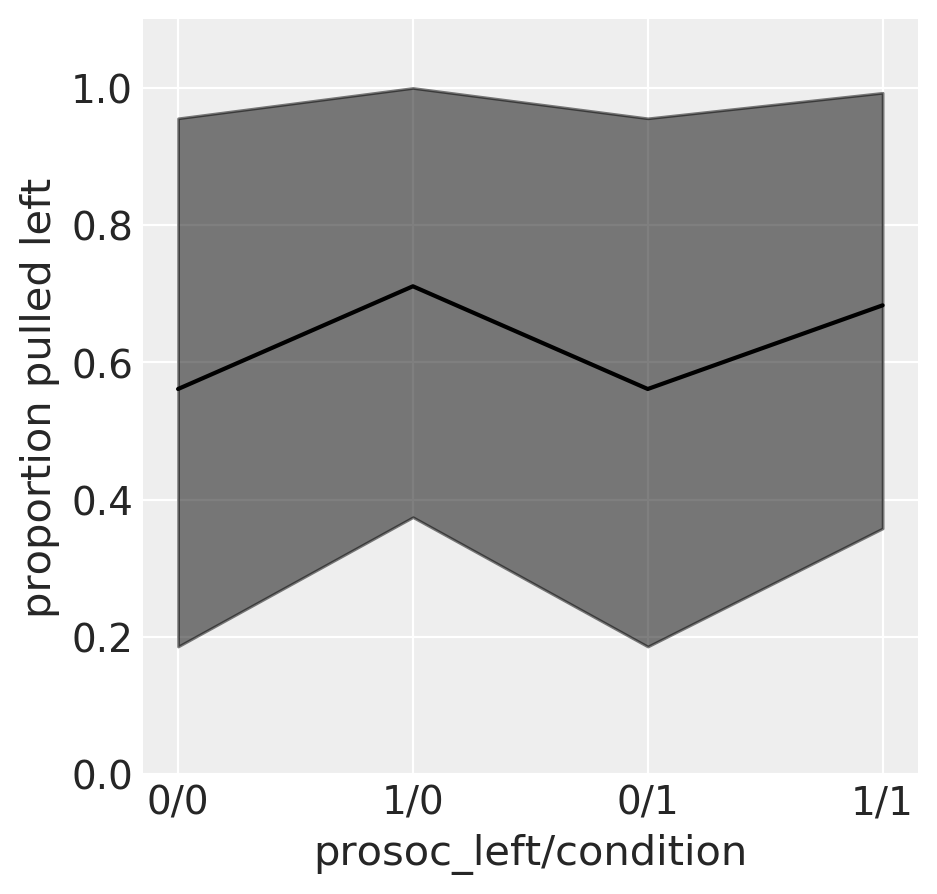

In [40]:
pred_raw = np.asarray([p_link(p_l, c_d, a_actor_sims, trace_12_4) 
                       for p_l, c_d in zip(prosoc_left, condition)]).T
pred_p = pred_raw.mean(axis=0)

_, ax = plt.subplots(1, 1, figsize=(5, 5))
az.plot_hpd(range(4), pred_raw, credible_interval=.89, color='k', smooth=False)
ax.plot(pred_p, color='k')

ax.set_ylim(0, 1.1)
ax.set_xlabel("prosoc_left/condition")
ax.set_ylabel("proportion pulled left")
plt.xticks(range(4), ("0/0","1/0","0/1","1/1"));

#### Code 12.37

In [41]:
def sim_actor(tr, i):
    sim_a_actor = np.random.randn()*tr['sigma_actor'][i]
    P = np.array([0, 1, 0, 1])
    C = np.array([0, 0, 1, 1])
    p = logistic(tr['a'][i] + sim_a_actor + (tr['bp'][i] + tr['bpC'][i]*C)*P)
    return p

sim_actor(trace_12_4, 0)

array([0.98207855, 0.98991097, 0.98207855, 0.99157905])

#### Code 12.38

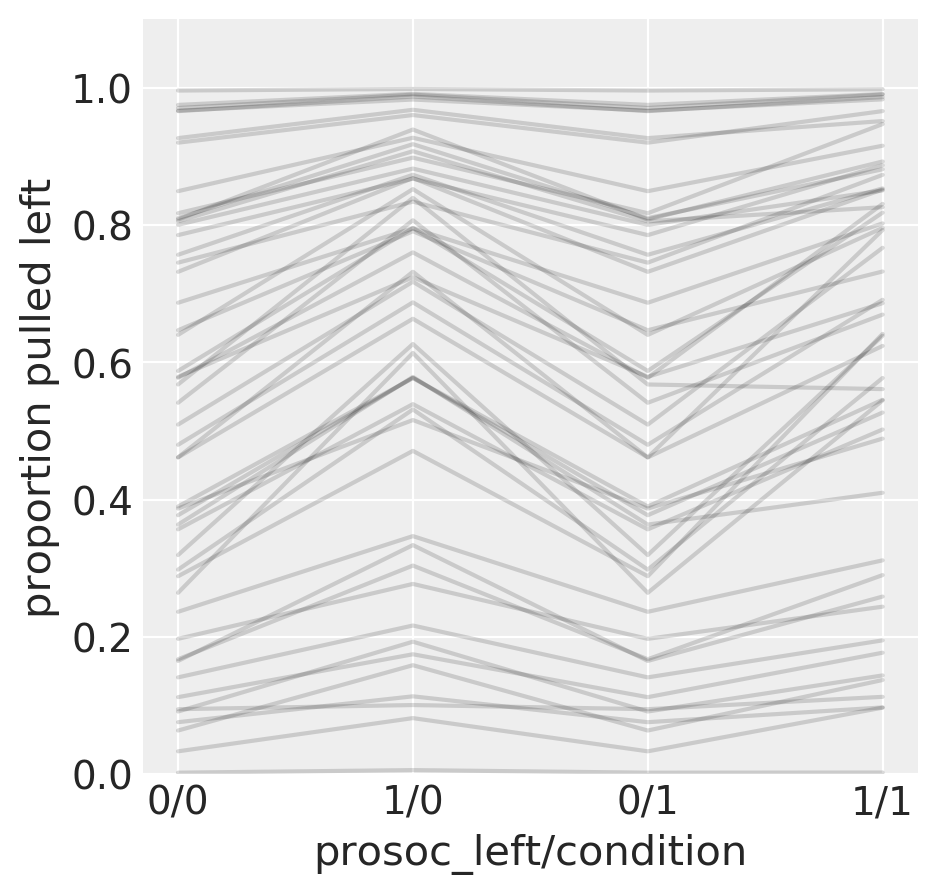

In [42]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(50):
    ax.plot(sim_actor(trace_12_4, i), color='k', alpha=.15)

ax.set_ylim(0, 1.1)
ax.set_xticks(range(4), ("0/0","1/0","0/1","1/1"))
ax.set_xlabel("prosoc_left/condition")
ax.set_ylabel("proportion pulled left")
plt.xticks(range(4), ("0/0","1/0","0/1","1/1"));

#### Code 12.39

In [43]:
dk = pd.read_csv('Data/Kline', sep=";")
dk.loc[:, 'log_pop'] = np.log(dk.population)
Nsociety = dk.shape[0]
dk.loc[:, 'society'] = np.arange(Nsociety)

with pm.Model() as m_12_6:
    sigma_society = pm.HalfCauchy('sigma_society', 1)
    a_society = pm.Normal('a_society', 0, sigma_society, shape=Nsociety),
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 1)
    lam = pm.math.exp(a + a_society + bp*dk.log_pop)
    obs = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_12_6 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [bp, a, a_society, sigma_society]
100%|██████████| 6000/6000 [02:11<00:00, 45.77it/s]


#### Code 12.40

In [44]:
sigma_society = trace_12_6.get_values('sigma_society', combine=True)[:, None]
a_society_sims = np.random.normal(loc=0, scale=sigma_society)
log_pop_seq = np.linspace(6, 14, 30)
a_post = trace_12_6.get_values(varname='a', combine=True)[:, None]
bp_post = trace_12_6.get_values(varname='bp', combine=True)[:, None]
link_m12_6 = np.exp(a_post + a_society_sims + bp_post*log_pop_seq)

#### Code 12.41

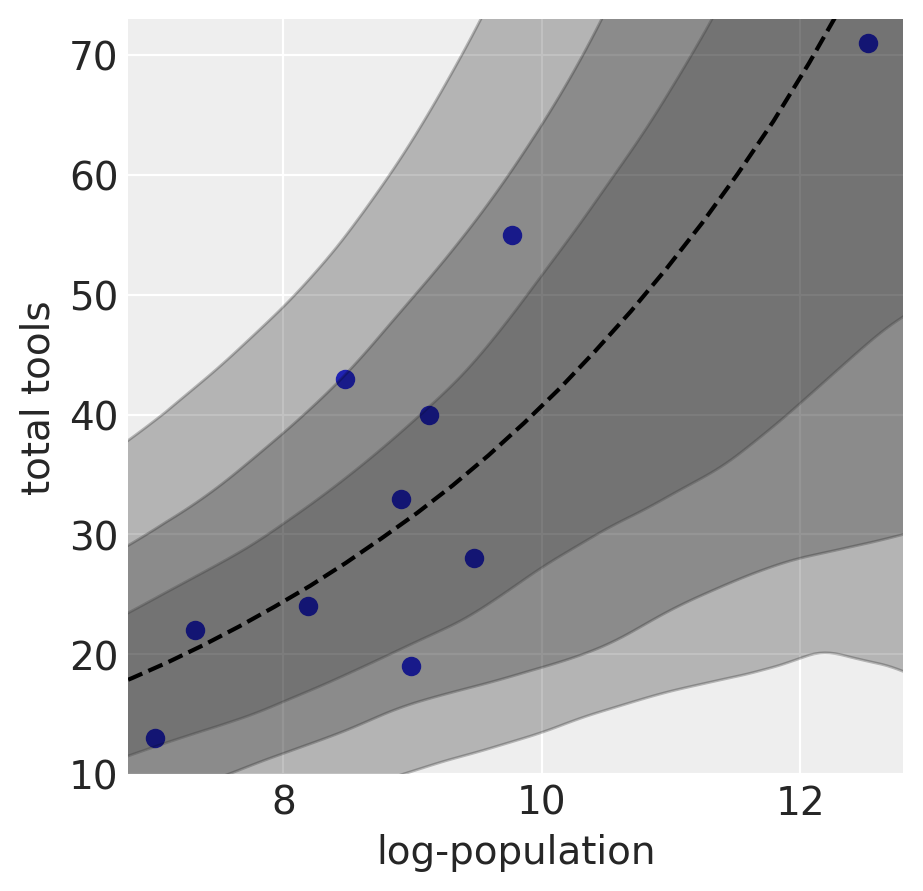

In [45]:
# plot raw data
_, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.scatter(dk.log_pop, dk.total_tools)

axes.plot(log_pop_seq, np.median(link_m12_6, axis=0), '--', color='k')

for alpha in [.67, .89, .97]: 
    mu_hpd = pm.hpd(link_m12_6, alpha=alpha)
    az.plot_hpd(log_pop_seq, link_m12_6, credible_interval=alpha, color='k',
                fill_kwargs={'alpha':alpha*.25})

axes.set_xlabel('log-population', fontsize=14)
axes.set_ylabel('total tools', fontsize=14)
axes.set_xlim(6.8, 12.8)
axes.set_ylim(10, 73);

In [46]:
import sys, IPython, scipy, matplotlib
print("""This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nArviZ {}\nNumPy {}\nSciPy {}\nMatplotlib {}\n""".format(sys.version[:5], IPython.__version__, pm.__version__, az.__version__, np.__version__, scipy.__version__, matplotlib.__version__))

This notebook was created using:
Python 3.7.3
IPython 7.5.0
PyMC3 3.7
ArviZ 0.4.1
NumPy 1.16.3
SciPy 1.2.1
Matplotlib 3.0.3

